In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict

from datasets import load_dataset
from wordcloud import  WordCloud, STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import gensim

import spacy

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading the dataset and inspecting the features

In [ ]:
# Load the dataset
dataset = load_dataset("ShubhamChoksi/IMDB_Movies")

# The dataset object is a dictionary-like object with keys corresponding to the splits of the dataset.
# Common splits include 'train', 'test', and 'validation', but this can vary by dataset.
# To access data, you specify the split and then index into it, like accessing rows in a dataframe.

# For example, to access the first element of the training split:
if "train" in dataset:
    first_train_example = dataset["train"][0]
    print(first_train_example)
else:
    print("Train split does not exist in this dataset.")

# If you're not sure what splits are available, you can check the keys of the dataset object:
print("Available splits:", list(dataset.keys()))

# And to see the structure of an example entry:
print("Example structure:", dataset["train"].features if "train" in dataset else "Train split not available")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'Name': 'First Knight', 'rating': 6.0, 'No_of_ratings': '77K', 'user': '226', 'critics': 54.0, 'Movie_Info': 'Mel Gibson was attached to this project at one stage, but chose to direct and star in Braveheart (1995) instead.,As Lancelot chases the horse a telephone pole is visible, with barbed wire around it.,King Arthur: May God grant us the wisdom to discover right, the will to choose it, and the strength to make it endure.,Featured in Siskel & Ebert: First Knight/Party Girl/Species/Batman: Mask of the Phantasm/Il Postino (1995),I am a regular Hollywood movie buff, and heavily rely on IMDb user ratings, before watching any movie than relying on any other sources, and I prefer to watch movies which are usually rated at least 7 out of 10.\n\nSo when I had a chance to see the movie First Knight, I was in a doubt whether to watch this movie with a low rating of 5.6/10, even with great actors like Sean Connery and Richard Gere, or to skip to some other movie.\n\nLuckily I decided to give i

#Convert the dataset into a Pandas DataFrame

In [ ]:
# converted to a Pandas DataFrame
df = pd.DataFrame(dataset['train'])

#The ratings have values like 77K => process K to 1e3, and M to 1e6

In [ ]:
# Preprocess 'No_of_ratings' to convert 'K' and 'M' and handle None values
def convert_ratings(value):
    if pd.isnull(value):
        return np.nan  # Choose np.nan or 0 based on how you wish to handle missing values
    if 'K' in value:
        return float(value.replace('K', '')) * 1e3
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6
    return float(value)

df['No_of_ratings'] = df['No_of_ratings'].apply(convert_ratings)

#User values are string though they are numbers, convert them to numeric

In [ ]:
# Ensure 'user' is numeric and handle None/missing values
df['user'] = pd.to_numeric(df['user'], errors='coerce')  # Converts invalid parsing to NaN

# Ensure 'rating' and 'critics' are within valid ranges and non-null

In [ ]:
df.dropna(subset=['rating', 'critics'], inplace=True)
df = df[(df['rating'] >= 0) & (df['rating'] <= 10)]

# Clean 'Movie_Info' text, replacing new lines with space and stripping leading/trailing spaces

In [ ]:
df['Movie_Info'] = df['Movie_Info'].str.replace('\n', ' ', regex=False).str.strip()

# 'user' has some missing values => use imputation to fill the missing values with the median

In [ ]:
# Median imputation for 'user'
df['user'] = df['user'].fillna(df['user'].median())

# Confirm no more missing values in 'user'
assert df['user'].isnull().sum() == 0, "There are still missing values in 'user'"


# There are duplicates => removing duplicate rows

In [ ]:
# For a more complex definition of uniqueness, include multiple columns in the subset
df = df.drop_duplicates(subset=['Name', 'Movie_Info'], keep='first')
df = df.drop_duplicates(subset=['Name'], keep='first')
df = df.drop_duplicates(subset=['Movie_Info'], keep='first')

# Remove rows where 'Movie_Info' is missing

In [ ]:

# Remove rows where 'Movie_Info' is missing
df_cleaned = df.dropna(subset=['Movie_Info'])

# Confirm the removal
print(f"Original number of rows: {len(df)}")
print(f"Number of rows after removing missing 'Movie_Info': {len(df_cleaned)}")


Original number of rows: 4768
Number of rows after removing missing 'Movie_Info': 4767


# Reset the index after cleaning

In [ ]:
df_cleaned.reset_index(drop=True, inplace=True)

# End of cleaning

# Preprocessing

#Bin the ratings, which is a number between 0-10, into three categories Low, Medium, High

In [ ]:
# binning 'rating' into categories
bins = [0, 5, 8, 10]
labels = ['Low', 'Medium', 'High']
df_cleaned['Rating_Category'] = pd.cut(df_cleaned['rating'], bins=bins, labels=labels)


<ipython-input-13-00e637ae3d48>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Rating_Category'] = pd.cut(df_cleaned['rating'], bins=bins, labels=labels)


#Process Movie_Info => remove the stopwords, tokenize and lemmatize

In [ ]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Tokenization and lemmatization
    tokens = nltk.word_tokenize(text.lower())
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(lemmatized_tokens)

# Apply text preprocessing
df_cleaned['Movie_Info_Preprocessed'] = df_cleaned['Movie_Info'].fillna("").apply(preprocess_text)

<ipython-input-14-2ae5e37efba3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Movie_Info_Preprocessed'] = df_cleaned['Movie_Info'].fillna("").apply(preprocess_text)


#Observe the first 10 rows after cleaning

In [ ]:
df_cleaned.head(10)

,Name,rating,No_of_ratings,user,critics,Movie_Info,Rating_Category,Movie_Info_Preprocessed
0,First Knight,6.0,77000.0,226.0,54.0,Mel Gibson was attached to this project at one...,Medium,mel gibson attached project one stage chose di...
1,First Man,7.3,198000.0,53.0,496.0,Mark Armstrong and Rick Armstrong said that th...,Medium,mark armstrong rick armstrong said film contai...
2,First Man into Space,5.4,1700.0,40.0,31.0,The pilot in the stock footage sequences is Ch...,Medium,pilot stock footage sequence chuck commander p...
3,First of May,6.8,454.0,13.0,3.0,Charles Nelson Reilly survived the worst circu...,Medium,charles nelson reilly survived worst circus di...
4,The First Purge,5.2,69000.0,599.0,234.0,Blumhouse Productions has been a major force i...,Medium,blumhouse production major force horror genre ...
5,First Reformed,7.1,61000.0,414.0,279.0,Amanda Seyfried was pregnant during the produc...,Medium,amanda seyfried pregnant physician describes c...
6,First Sunday,4.6,11000.0,48.0,66.0,Tracy Morgan shot the whole movie with an ankl...,Low,tracy morgan shot whole movie ankle bracelet a...
7,The First Time,6.8,73000.0,93.0,22.0,"The two main cast, Dylan O'Brien and Britt Rob...",Medium,two main cast dylan britt robertson dated aubr...
8,The First Wave,7.0,1100.0,19.0,23.0,"Breathe Written by Jon Batiste,This is a great...",Medium,breathe written jon batiste great documentary ...
9,The First Wives Club,6.4,53000.0,152.0,49.0,"In an interview, Bette Midler mentioned that a...",Medium,interview bette midler mentioned three main ca...


#Observe the stats of the dataset after cleaning

In [ ]:
df_cleaned.describe()

,rating,No_of_ratings,user,critics
count,4767.000000,4.767000e+03,4767.000000,4767.000000
mean,6.333249,4.780520e+04,119.778897,68.155234
std,1.129106,1.393525e+05,173.522257,95.980407
min,1.400000,1.000000e+01,1.000000,1.000000
25%,5.700000,1.400000e+03,19.000000,11.000000
50%,6.400000,5.600000e+03,53.000000,32.000000
75%,7.100000,2.800000e+04,134.000000,83.000000
max,9.500000,2.200000e+06,999.000000,904.000000


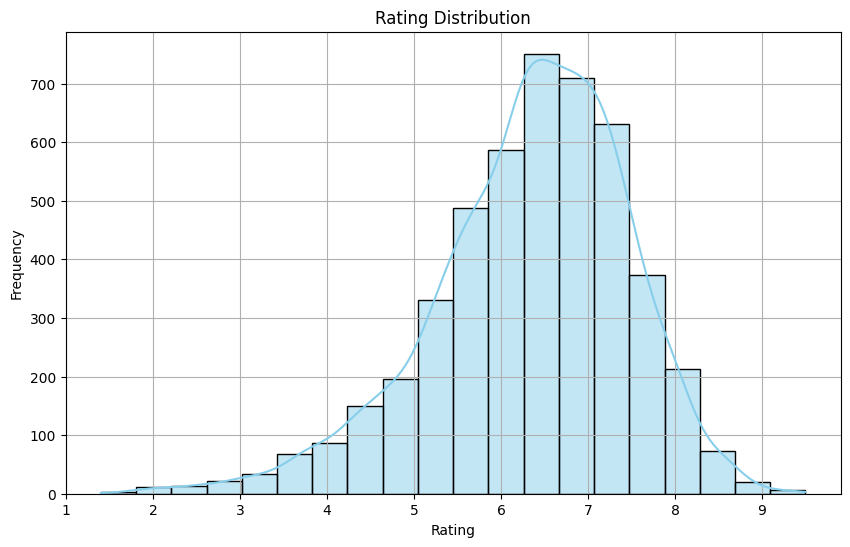

In [ ]:
# Plot rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['rating'], bins=20, kde=True, color='skyblue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#Filter the ratings 75th percentile and above as the high rating and lower 25th percentile and below as the low rating

In [ ]:
# Calculate rating percentiles
high_rating_threshold = df_cleaned['rating'].quantile(0.75)
low_rating_threshold = df_cleaned['rating'].quantile(0.25)

# Filter datasets for high and low rating movies
high_rating_movies = df_cleaned[df_cleaned['rating'] >= high_rating_threshold]
low_rating_movies = df_cleaned[df_cleaned['rating'] <= low_rating_threshold]


In [ ]:
# Combine descriptions
high_rating_text = ' '.join(high_rating_movies['Movie_Info'].fillna(""))
low_rating_text = ' '.join(low_rating_movies['Movie_Info'].fillna(""))


#Create a word cloud to visualize the words that were uniquely repeated in high-rating movies and low-rating movies separately

In [ ]:
# Function to generate and display a word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=100, width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Tokenize text
def preprocess_text(text):
    tokens = word_tokenize(text)
    return tokens

# Calculate word frequencies for high and low rating movies
high_rating_words = [word for desc in high_rating_movies['Movie_Info'].fillna("") for word in preprocess_text(desc)]
low_rating_words = [word for desc in low_rating_movies['Movie_Info'].fillna("") for word in preprocess_text(desc)]

# Calculate word frequencies
high_rating_word_freq = Counter(high_rating_words)
low_rating_word_freq = Counter(low_rating_words)

# Calculate total word counts for normalization
total_high_rating_words = sum(high_rating_word_freq.values())
total_low_rating_words = sum(low_rating_word_freq.values())

# Calculate relative frequency of each word
relative_high_rating_freq = {word: freq / total_high_rating_words for word, freq in high_rating_word_freq.items()}
relative_low_rating_freq = {word: freq / total_low_rating_words for word, freq in low_rating_word_freq.items()}

# Define a threshold for the relative frequency difference
threshold = 0.001

# Filter out common words based on relative frequency difference
words_specific_to_high_rating = {word for word in relative_high_rating_freq if word not in relative_low_rating_freq or (relative_high_rating_freq[word] - relative_low_rating_freq.get(word, 0)) > threshold}
words_specific_to_low_rating = {word for word in relative_low_rating_freq if word not in relative_high_rating_freq or (relative_low_rating_freq[word] - relative_high_rating_freq.get(word, 0)) > threshold}

# Generate word clouds for high and low rating movies
high_rating_specific_text = ' '.join(word for word in high_rating_words if word in words_specific_to_high_rating)
low_rating_specific_text = ' '.join(word for word in low_rating_words if word in words_specific_to_low_rating)



# Generate and display word cloud for high rating movies

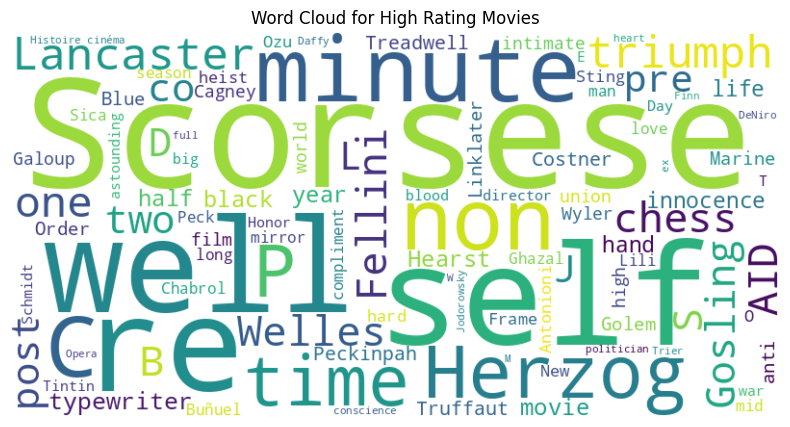

In [ ]:
generate_word_cloud(high_rating_specific_text, "Word Cloud for High Rating Movies")

# Generate and display word cloud for low rating movies

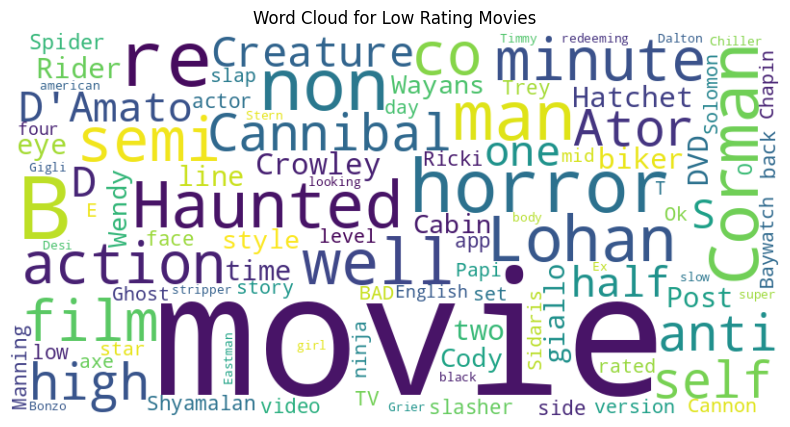

In [ ]:
generate_word_cloud(low_rating_specific_text, "Word Cloud for Low Rating Movies")

#Calculate the mean TF-IDF score for each word across all documents to find the top 10 words with the highest mean TF-IDF scores

In [ ]:
# Sample text data
text_data = df_cleaned['Movie_Info']

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(text_data)

# Get feature names to use as dataframe column headers
tfidf_feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

# Top 10 words with the highest mean TF-IDF scores

In [ ]:
# Find the mean TF-IDF score for each word across all documents
mean_tfidf_scores = tfidf_df.mean().sort_values(ascending=False)

# Display the top 10 words with the highest mean TF-IDF scores
print(mean_tfidf_scores.head(10))


film      0.083043
movie     0.068989
like      0.039453
good      0.034438
just      0.033747
story     0.032521
time      0.031131
great     0.027576
music     0.027316
really    0.026471
dtype: float64


# Display the distribution of TF-IDF Scores for "great"

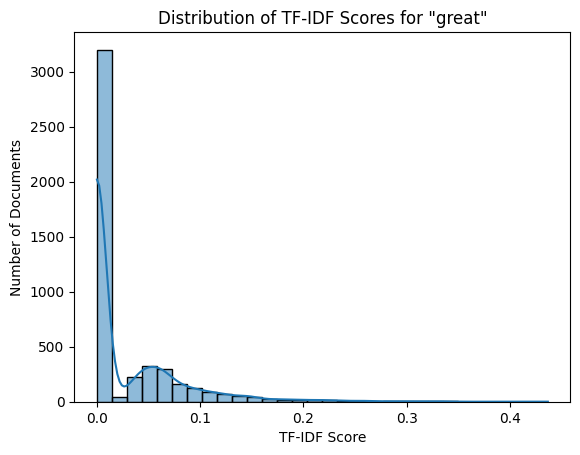

In [ ]:
# Plot the distribution of the TF-IDF score of a specific word
sns.histplot(tfidf_df['great'], bins=30, kde=True)
plt.title('Distribution of TF-IDF Scores for "great"')
plt.xlabel('TF-IDF Score')
plt.ylabel('Number of Documents')
plt.show()


# Display the distribution of TF-IDF Scores for "music"

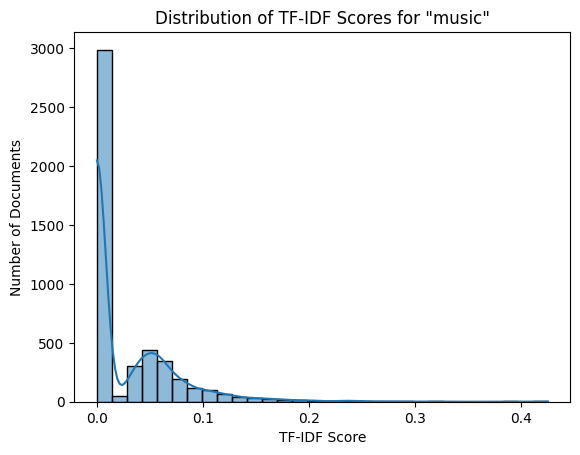

In [ ]:
# Plot the distribution of the TF-IDF score of a specific word
sns.histplot(tfidf_df['music'], bins=30, kde=True)
plt.title('Distribution of TF-IDF Scores for "music"')
plt.xlabel('TF-IDF Score')
plt.ylabel('Number of Documents')
plt.show()


# Calculate the percentage of movies mentioning "great" in each rating category

In [ ]:
# Example analysis for the word "great"
df_cleaned['has_great'] = df_cleaned['Movie_Info'].str.contains('great', case=False, na=False)

# Calculate the percentage of movies mentioning "great" in each rating category
great_mention_by_rating = df_cleaned.groupby('Rating_Category')['has_great'].mean() * 100

print(great_mention_by_rating)

Rating_Category
Low       20.754717
Medium    37.637638
High      43.617021
Name: has_great, dtype: float64


<ipython-input-25-ce9f8824c0f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['has_great'] = df_cleaned['Movie_Info'].str.contains('great', case=False, na=False)


# Display percentage of Movies Mentioning "great" by Rating Category

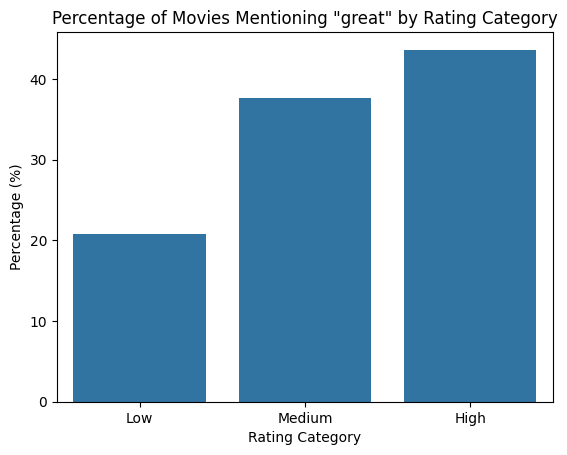

In [ ]:
# Example visualization for the word "great"
sns.barplot(x=great_mention_by_rating.index, y=great_mention_by_rating.values)
plt.title('Percentage of Movies Mentioning "great" by Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Percentage (%)')
plt.show()


# ====> Movies that mention "great" in their description tend to get a higher rating, though a hypothesis testing is required

# Calculate the percentage of movies mentioning "music" in each rating category

In [ ]:
# Example analysis for the word "music"
df_cleaned['has_music'] = df_cleaned['Movie_Info'].str.contains('music', case=False, na=False)

# Calculate the percentage of movies mentioning "film" in each rating category
music_mention_by_rating = df_cleaned.groupby('Rating_Category')['has_music'].mean() * 100

print(music_mention_by_rating)


Rating_Category
Low       27.101201
Medium    41.291291
High      35.106383
Name: has_music, dtype: float64


<ipython-input-27-3bd5c1eb05e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['has_music'] = df_cleaned['Movie_Info'].str.contains('music', case=False, na=False)


# Display percentage of Movies Mentioning "music" by Rating Category

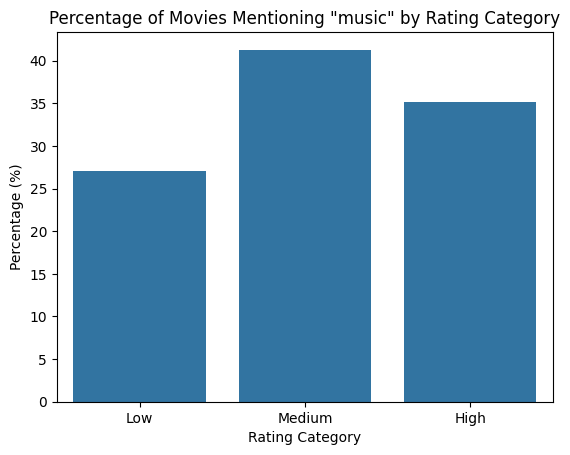

In [ ]:
# Example visualization for the word "film"
sns.barplot(x=music_mention_by_rating.index, y=music_mention_by_rating.values)
plt.title('Percentage of Movies Mentioning "music" by Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Percentage (%)')
plt.show()


# ====> Movies that mention "music" in their description tend to get a medium rating, though a hypothesis testing is required

# Calculate the following to compare the similarity between high rating and low rating Movie_Info
# Average Cosine Similarity within High Rating Movies
# Average Cosine Similarity within Low Rating Movies
# Average Cosine Similarity between High and Low Rating Movies

In [ ]:
# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(df_cleaned["Movie_Info_Preprocessed"])

# Get feature names to use as dataframe column headers
tfidf_feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)


# Transform the text data for high and low rating movies using the common vectorizer
tfidf_matrix_high = vectorizer.transform(high_rating_movies['Movie_Info'].fillna(""))
tfidf_matrix_low = vectorizer.transform(low_rating_movies['Movie_Info'].fillna(""))

# Calculate cosine similarity matrices
cosine_sim_high = cosine_similarity(tfidf_matrix_high)
cosine_sim_low = cosine_similarity(tfidf_matrix_low)
cosine_sim_cross = cosine_similarity(tfidf_matrix_high, tfidf_matrix_low)

# Compute average similarity scores, ignoring self-similarity (diagonal elements) for within-group comparisons
average_sim_high = np.mean(cosine_sim_high - np.eye(cosine_sim_high.shape[0]))
average_sim_low = np.mean(cosine_sim_low - np.eye(cosine_sim_low.shape[0]))
average_sim_cross = np.mean(cosine_sim_cross)

print(f"Average Cosine Similarity within High Rating Movies: {average_sim_high:.3f}")
print(f"Average Cosine Similarity within Low Rating Movies: {average_sim_low:.3f}")
print(f"Average Cosine Similarity between High and Low Rating Movies: {average_sim_cross:.3f}")


Average Cosine Similarity within High Rating Movies: 0.080
Average Cosine Similarity within Low Rating Movies: 0.073
Average Cosine Similarity between High and Low Rating Movies: 0.072


# The above shows that the movie_info of high rating movies have more similarity with each other, and the movie_info of low rating movies have comparatively less similarity with each other and the high rating ones.

# Let's cluster the data based on the tfidf_matrix
# Kmeans clustering

In [ ]:
# Assuming tfidf_matrix is available
kmeans = KMeans(n_clusters=5, random_state=42).fit(tfidf_matrix)

# Add cluster labels to the DataFrame
df_cleaned['Cluster_Label'] = kmeans.labels_

# Analyze clusters
for cluster in sorted(df_cleaned['Cluster_Label'].unique()):
    print(f"Cluster {cluster}:")
    print(df_cleaned[df_cleaned['Cluster_Label'] == cluster]['rating'].describe(), "\n")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
count    928.000000
mean       5.940086
std        1.202500
min        1.400000
25%        5.200000
50%        6.100000
75%        6.800000
max        8.500000
Name: rating, dtype: float64 

Cluster 1:
count    712.000000
mean       6.215590
std        1.165827
min        1.900000
25%        5.500000
50%        6.400000
75%        7.000000
max        9.200000
Name: rating, dtype: float64 

Cluster 2:
count    1120.000000
mean        6.559643
std         1.013984
min         1.900000
25%         6.000000
50%         6.700000
75%         7.300000
max         9.000000
Name: rating, dtype: float64 

Cluster 3:
count    1808.000000
mean        6.335177
std         1.035812
min         1.900000
25%         5.700000
50%         6.400000
75%         7.100000
max         8.900000
Name: rating, dtype: float64 

Cluster 4:
count    199.000000
mean       7.295980
std        1.199446
min        3.000000
25%        6.800000
50%        7.400000
75%        8.100000
max        9.500000
Name:

<ipython-input-30-adeaef42732d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Cluster_Label'] = kmeans.labels_


#  The above clustering analysis for ratings suggest that movies within each cluster tend to exhibit similar rating patterns. Cluster 0 exibits lower ratings and cluster 4 exibits higher ratings.

# Understanding these clusters can provide insights into audience preferences, movie characteristics, and potentially aid in targeted marketing or content recommendation strategies. Additionally, it may help in identifying factors that contribute to higher or lower ratings within specific movie genres or themes.

# Let's find topics in the Movie_Info texts
# Perform topic modeling using LDA on the preprocessed movie information text data and print the top words for each topic

In [ ]:
# Prepare texts for LDA
texts = [[word for word in document.lower().split() if word not in STOPWORDS]
         for document in df_cleaned['Movie_Info_Preprocessed']]

# Create a corpus from a list of texts
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Print topics
topics = lda.print_topics(num_words=4)
for topic in topics:
    print(topic)


(0, '0.003*"cohn" + 0.002*"merman" + 0.002*"rico" + 0.002*"milford"')
(1, '0.008*"godzilla" + 0.005*"chess" + 0.004*"pirate" + 0.004*"britney"')
(2, '0.019*"film" + 0.009*"movie" + 0.006*"scene" + 0.005*"time"')
(3, '0.008*"khan" + 0.006*"song" + 0.005*"lew" + 0.005*"kapoor"')
(4, '0.004*"nick" + 0.003*"ice" + 0.003*"cube" + 0.003*"cooper"')
(5, '0.035*"movie" + 0.012*"like" + 0.011*"good" + 0.009*"film"')
(6, '0.005*"lohan" + 0.004*"bug" + 0.004*"lindsay" + 0.003*"larry"')
(7, '0.029*"film" + 0.007*"story" + 0.006*"life" + 0.006*"love"')
(8, '0.004*"buñuel" + 0.003*"connors" + 0.003*"kat" + 0.002*"denton"')
(9, '0.008*"woody" + 0.007*"creed" + 0.007*"rocky" + 0.005*"allen"')


#  Identify and assign the dominant topic for each document in the corpus and store this information in the DataFrame

In [ ]:
# Assuming 'lda' is your trained LdaModel and 'corpus' is the corpus used for training
dominant_topics = []
for document in corpus:
    # Get topic distribution for the document
    topic_distribution = lda.get_document_topics(document)
    # Sort topics by contribution and get the highest contributing topic
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0]
    dominant_topics.append(dominant_topic)

# Add the dominant topic as a column in your DataFrame
df_cleaned['Dominant_Topic'] = dominant_topics


<ipython-input-32-753d28edc86d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Dominant_Topic'] = dominant_topics


#  Calculate the average rating for each dominant topic identified

In [ ]:
# Calculate the average rating for each dominant topic
average_ratings_by_topic = df_cleaned.groupby('Dominant_Topic')['rating'].mean()

# Sort the results for better visualization
sorted_average_ratings_by_topic = average_ratings_by_topic.sort_values(ascending=False)

print(sorted_average_ratings_by_topic)


Dominant_Topic
7    6.921500
1    6.733333
4    6.344444
2    6.334581
5    6.099000
3    5.375000
0    5.000000
9    4.600000
Name: rating, dtype: float64


#  Visualize the average movie rating for each dominant topic

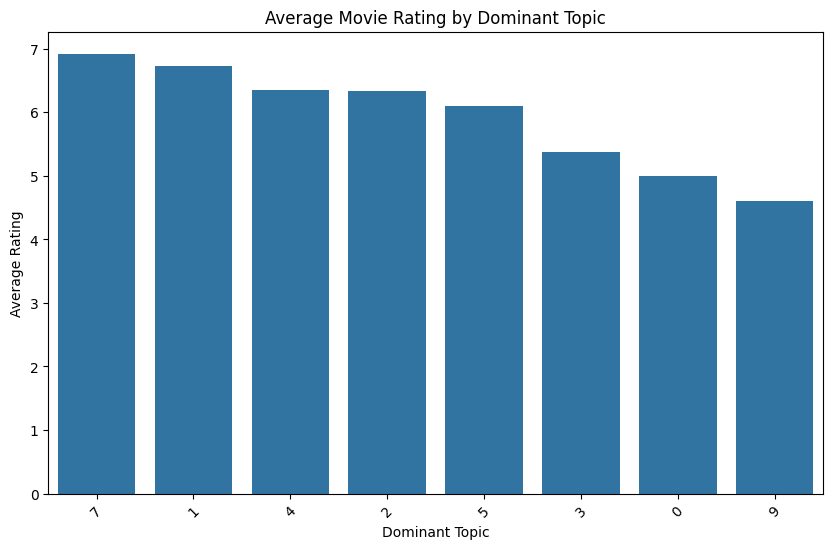

In [ ]:
# Convert the Series to a DataFrame and reset the index
sorted_df = sorted_average_ratings_by_topic.reset_index()
sorted_df.columns = ['Dominant Topic', 'Average Rating']

# Sort the DataFrame by 'Average Rating'
sorted_df = sorted_df.sort_values('Average Rating', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Dominant Topic', y='Average Rating', data=sorted_df, order=sorted_df['Dominant Topic'])

plt.title('Average Movie Rating by Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Average Rating')

# Setting x-ticks manually
plt.xticks(ticks=range(len(sorted_df)), labels=sorted_df['Dominant Topic'], rotation=45)

plt.show()

# Let's find entities; e.g "PERSON" to identify the ratings based on their mention

In [ ]:
# Load spaCy's small English model
nlp = spacy.load("en_core_web_sm")

# Initialize a dictionary to hold entities and their associated ratings
entity_ratings = defaultdict(list)

for index, row in df_cleaned.iterrows():
    doc = nlp(row['Movie_Info_Preprocessed'])
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            entity_ratings[ent.text].append(row['rating'])


# Calculate the average rating for each "PERSON" entity mentioned in the dataset and count the number of mentions for each entity

In [ ]:
# Calculate average rating for each entity and count the number of mentions
entity_avg_ratings = {entity: sum(ratings)/len(ratings) for entity, ratings in entity_ratings.items() if len(ratings) > 1}
entity_mentions = {entity: len(ratings) for entity, ratings in entity_ratings.items()}

# Filter entities mentioned in at least X movies for significance (e.g., X could be 5)
significant_entities = {entity: avg for entity, avg in entity_avg_ratings.items() if entity_mentions[entity] >= 10}

# Sort entities by average rating
sorted_entities_by_rating = sorted(significant_entities.items(), key=lambda item: item[1], reverse=True)

# Extract top 5 and bottom 5 entities
top_5_entities = sorted_entities_by_rating[:5]
bottom_5_entities = sorted_entities_by_rating[-5:]


# Extract top 5 and bottom 5 "PERSON" entities and their average ratings

In [ ]:
# Extract top 5 and bottom 5 entities and their average ratings
top_5_entities = sorted_entities_by_rating[:5]
bottom_5_entities = sorted_entities_by_rating[-5:]

# Combine top and bottom entities
entities = [entity for entity, _ in top_5_entities] + [entity for entity, _ in bottom_5_entities]
avg_ratings = [rating for _, rating in top_5_entities] + [rating for _, rating in bottom_5_entities]


# Visualize the top 5 bottom 5 "PERSON" entities ranked by their average movie rating

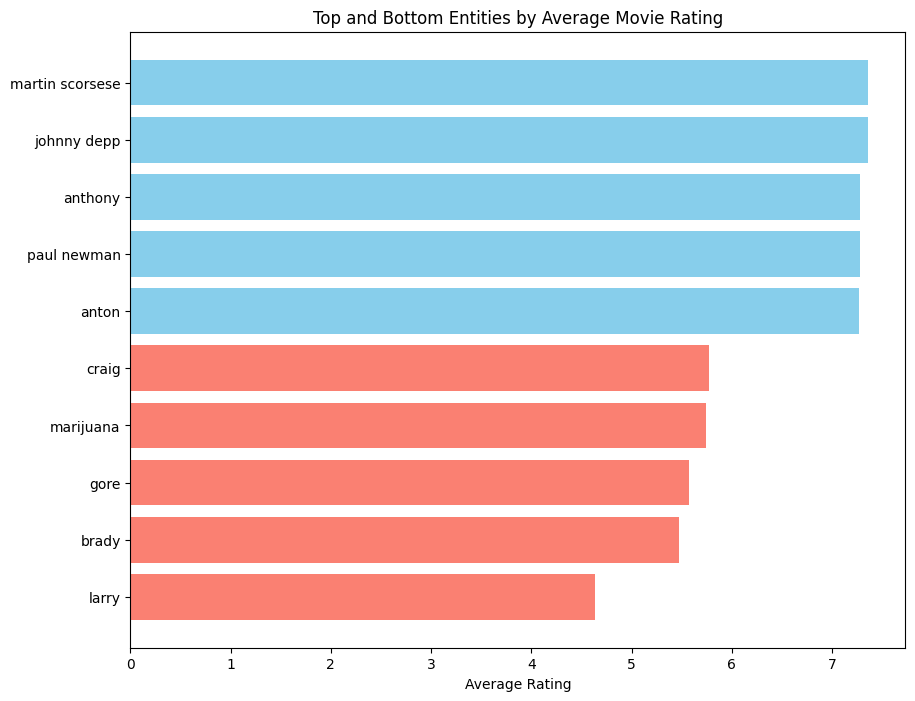

In [ ]:
# Create colors for top and bottom entities
colors = ['skyblue'] * 5 + ['salmon'] * 5

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(entities, avg_ratings, color=colors)
plt.xlabel('Average Rating')
plt.title('Top and Bottom Entities by Average Movie Rating')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest ratings on top
plt.show()

# Let's do the same thing for "ORG" entity

In [ ]:
# Load spaCy's small English model
nlp = spacy.load("en_core_web_sm")

# Initialize a dictionary to hold entities and their associated ratings
entity_ratings = defaultdict(list)

for index, row in df_cleaned.iterrows():
    doc = nlp(row['Movie_Info'])
    for ent in doc.ents:
        if ent.label_ == "ORG":
            entity_ratings[ent.text].append(row['rating'])

# Calculate average rating for each "ORG" entity and count the number of mentions

In [ ]:
# Calculate average rating for each entity and count the number of mentions
entity_avg_ratings = {entity: sum(ratings)/len(ratings) for entity, ratings in entity_ratings.items() if len(ratings) > 1}
entity_mentions = {entity: len(ratings) for entity, ratings in entity_ratings.items()}

# Filter entities mentioned in at least X movies for significance (e.g., X could be 5)
significant_entities = {entity: avg for entity, avg in entity_avg_ratings.items() if entity_mentions[entity] >= 10}

# Sort entities by average rating
sorted_entities_by_rating = sorted(significant_entities.items(), key=lambda item: item[1], reverse=True)

# Extract top 5 and bottom 5 "ORG" entities and their average ratings

In [ ]:
# Extract top 5 and bottom 5 entities and their average ratings
top_5_entities = sorted_entities_by_rating[:5]
bottom_5_entities = sorted_entities_by_rating[-5:]

# Combine top and bottom entities
entities = [entity for entity, _ in top_5_entities] + [entity for entity, _ in bottom_5_entities]
avg_ratings = [rating for _, rating in top_5_entities] + [rating for _, rating in bottom_5_entities]


# Visualize the top 5 bottom 5 "ORG" entities ranked by their average movie rating

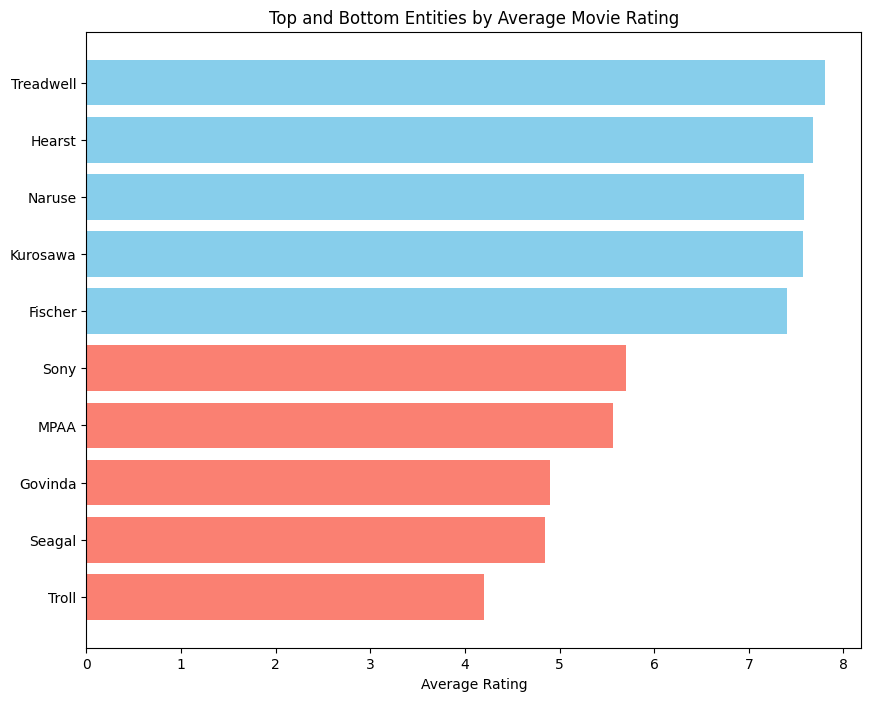

In [ ]:
# Create colors for top and bottom entities
colors = ['skyblue'] * 5 + ['salmon'] * 5

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(entities, avg_ratings, color=colors)
plt.xlabel('Average Rating')
plt.title('Top and Bottom Entities by Average Movie Rating')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest ratings on top
plt.show()